# Route planner for London #

This is the main code for the route planner. Widgets are provided to input the required values. The functions introduced are utilised to process the data and for filtering. The output gives a selection of options from which one can choose to output the shortest path for the chosen location

## Requirements for the project

packages - geopy, geopandas, numpy, utm, folium, geog, json, shapely, plotly_express, matplotlib, osmnx, networkx

Additional packages used - warnings (to ignore the ShapelyDeprecationWarning)

In [1]:
## Import all the packages used for the project ##

from geopy.geocoders import Nominatim
import geopandas as gpd
import numpy as np
import utm
import folium
from IPython.display import display
from ipywidgets import Dropdown
import json
import geog
import shapely.geometry
import plotly_express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import osmnx as ox
import networkx as nx
ox.settings.log_console=True
ox.settings.use_cache=True

## Introduce functions required for the process

This section includes all the functions required for processing the data and filtering

In [9]:

## To convert latitude/longitude to UTM coordinates
def utm_dist(lat,long):
    #convert lat/long to utm
    u = utm.from_latlon(lat, long)
    #return UTM coordinates
    return (u[0],u[1])

def printmd(string):
    display(Markdown(string))   

## Function to return the maximum distance that can be travelled based on the mode of travel and time##
def dist_fn(mode, time):
    #create a dictionary with average speed for each mode of travel
    speed_dict = {'walk':5, 'drive':50, 'bike':19}
    #convert the speed to m/s
    sp = speed_dict[mode]/3.6
    #find distance from given speed and time
    dist = sp * time
    #return distance
    return dist

## Function to find the latitude/longitude of the input location ##
def latlong(place):
    #Initialize Nominatim
    geolocator = Nominatim(user_agent="MyApp")
    #Get the geo-coordinates of current location
    coordinates = geolocator.geocode(place)
    #Latitude of the place
    lat=float(coordinates.latitude)
    #Longitude of the place
    long=float(coordinates.longitude)
    orig = (lat,long)
    return orig

## Function to import the dataset based on the type of place to visit ##
def data(interest):
    #dictionary with place of visit as keys and columns to be extracted as values
    dict1={'Tourist_spots':['addr:postcode','name','opening_hours','tourism','wheelchair:description','geometry'],\
           'pub':['id','addr:postcode','name','opening_hours','website','geometry'],\
           'cafe':['id','addr:postcode','name','opening_hours','outdoor_seating','geometry'],\
           'restaurant':['id','addr:postcode','addr:street','name','opening_hours','phone','geometry']}
    #open the geojson file for the corresponding place of interest   
    df = gpd.read_file(interest+'.geojson')
    #remove the rows where 'name' is NAN
    df = df.dropna(axis=0, subset=['name'])
    #Extract columns based on the point of interest - from dict1
    df=df[dict1[interest]]
    #return the dataframe
    return df


def dropdown_eventhandler(change):
    print(change.new)

def path(G, orig, dest):
    #find the nearest nodes for the current location and the target
    orig_node, dest_node = ox.nearest_nodes(G,X=[orig[0], dest[0]],\
                            Y=[orig[1], dest[1]])
    #if there is a path that can be found between the two nodes in G
    if nx.has_path(G, orig_node, dest_node):
        #opt_route is the shortest path between orig_node and dest_node where travel_time was considered as the edge weight
        opt_route = nx.shortest_path(G, orig_node, dest_node, weight='travel_time')
        return opt_route
    #if there is no such route
    else:
        #return 0
        return 0
    
## Function for geofencing - filter the data points inside the custom polygon ##
def filtr(df, mask):
    #check whether the points are inside or outside of the polygon
    mask_geofence = df.within(mask)
    #save the value as a new column geofence
    df.loc[:,'geofence'] = mask_geofence
    #drop the rows where geofence is False
    df = df.loc[df['geofence'] == True]
    #drop the column geofence and return the dataframe
    return df.drop(['geofence'], axis=1)

def find_time(G, route, att):
    #sum all the travel times on edges in the path together to get the total time
    time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, att)))
    return time
    return time

## Create widgets needed for the inputs

In [10]:
## User inputs ##

#to input the current location
place = str(input("Enter your current location:"))
#to input max travel time
time_in_min = int(input("Enter the maximum travel time(in min):"))
#convert time from minutes to seconds
time = time_in_min*60

Enter your current location:Stratford, London
Enter the maximum travel time(in min):3


In [21]:
print("\n Choose the mode of travel:")
#create the list for the dropdown
mode_list = ['drive', 'walk','bike']
#dropdown with mode_list as the options
mode_drop = Dropdown(options=mode_list)
mode_drop.observe(dropdown_eventhandler, names='value')
#display the dropdown
display(mode_drop)

print("\n Choose the type of place you want to visit:")
#create the list for the dropdown
visit_list = ['pub','cafe','restaurant','Tourist_spots']
#dropdown with visit_list as the options
visit_drop = Dropdown(options=visit_list)
visit_drop.observe(dropdown_eventhandler, names='value')
#display the dropdown
display(visit_drop)


 Choose the mode of travel:


Dropdown(options=('drive', 'walk', 'bike'), value='drive')


 Choose the type of place you want to visit:


Dropdown(options=('pub', 'cafe', 'restaurant', 'Tourist_spots'), value='pub')

cafe


In [22]:
#Assign the values from mode_drop to mode
mode = mode_drop.value
#Assign the values from visit_drop to visit
visit = visit_drop.value

## Coordinates for the current location

We find the latitude/longitude values for the input location

In [23]:
# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")
#Get the geo-coordinates of current location
coordinates = geolocator.geocode(place)
#Latitude of the current location
lat=float(coordinates.latitude)
#Longitude of the current location
long=float(coordinates.longitude)
#Latitude/Longitude coordinate
orig = (lat,long)
#print the address for current location
print("Current location is", coordinates, orig)

Current location is Stratford, Meridian Square, Stratford Marsh, London Borough of Newham, London, Greater London, England, E15 1DE, United Kingdom (51.541289, -0.0035472)


## Import data and create polygon for geofencing

Here, we import the file based on the point of interest. Maximum distance that a person can travel from the input place by the given mode of travel is found and use this distance to find a circle with centre as the input place and radius as the distance. Plot the figure with the circle and the datapoints.

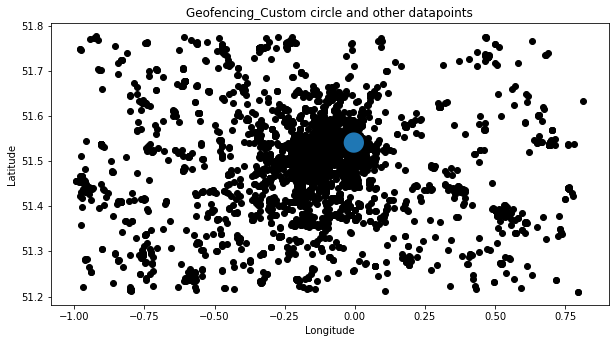

In [24]:
#import the dataset based on the type of place to visit with specific columns
df = data(visit)
# the maximum distance that can be travelled based on the mode of travel and time
dist = dist_fn(mode, time)

#Create Point geometric object - `Point' takes positional coordinate values or point tuple parameters
p = shapely.geometry.Point((long,lat))
n_points = 500
#produce 500 (n_points) evenly spaced numbers between 0 and 360
angles = np.linspace(0, 360, n_points)
# buffer a single point by passing in multiple angles (values of `angles).
polygon = geog.propagate(p, angles, dist)

#Save the points as a geojson file to construct the circle required for geofencing
with open('Circle.geojson', 'w') as f:
    f.write(json.dumps(shapely.geometry.mapping(shapely.geometry.Polygon(polygon))))

#Load the geojson file Circle.geojson to a geodataframe
Circle = gpd.read_file("Circle.geojson")

## Plotting the circle and all the datapoints in df ##
#Create a figure and a set of subplots with given figure size
fig, ax = plt.subplots(figsize=(10,10))
#Title of the plot
plt.title('Geofencing_Custom circle and other datapoints')
df.plot(ax=ax, color='black')
#Set x label 
ax.set_xlabel("Longitude")
#Set y label
ax.set_ylabel("Latitude")
Circle.plot(ax=ax)
plt.show()

## Filter data inside the boundary

In [25]:
#create a mask using the coordinates
mask = (Circle.loc[0, 'geometry'])

#apply filtr function to filter the data points which is within the circle
df = filtr(df,mask)

#save the latitude/longitude values in appropriate columns
df["long"] = df['geometry'].map(lambda p: p.x)
df["lat"] = df['geometry'].map(lambda p: p.y)

## plot the filterd points on the map - appears as blue dots near the current location ##
#access a public Mapbox access token.
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
# make scatter plots on Mapbox maps
px.scatter_mapbox(df, lat="lat", lon="long",mapbox_style="open-street-map",size_max=6, zoom=10,\
                  width=1920, height=1080)

## Creating projected graph

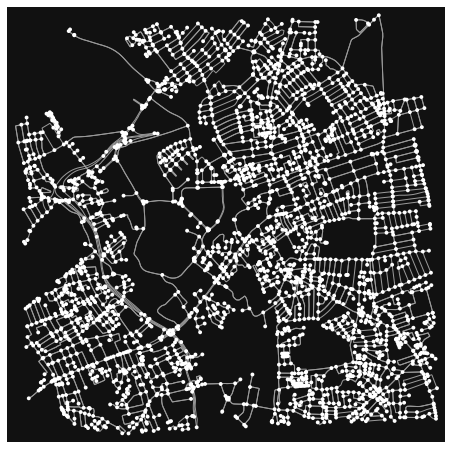

In [16]:
## CREATING GRAPH ##
#create a graph with orig as the centre,  distance - dist for the selected mode of travel
G = ox.graph_from_point(center_point=orig, dist=dist, network_type=mode)
#Add speed as edge attribute
G = ox.speed.add_edge_speeds(G)
#Add travel time as edge attribute
G = ox.speed.add_edge_travel_times(G)
#Project the graph to utm for better accuracy
G_proj = ox.project_graph(G)
#plot the graph
fig, ax = ox.plot_graph(G_proj)

## Finding shortest path and travel time

In [17]:
#convert the latitude/longitude values of the current location into utm coordinates
orig_utm = utm_dist(lat,long)
# convert the latitude/longitude of all the data points into utm coordinates
df['loc'] = df['geometry'].map(lambda p: utm_dist(p.y,p.x))

#FINDING SHORTEST ROUTE AND TRAVEL TIME
#find route using path function
df['route'] = df['loc'].map(lambda p: path(G_proj, orig_utm, p))
#remove the rows where value of 'route' is 0
df=df[df['route'] !=0]
#use function find_time to find the travel time for the corresponding shortest path
df['time'] = df['route'].map(lambda p: find_time(G_proj, p,"travel_time"))
df.head()

,id,addr:postcode,name,opening_hours,website,geometry,long,lat,loc,route,time
374,node/160548974,E3 5AA,The Morgan Arms,Mo-Th 12:00-23:00; Fr-Sa 12:00-24:00; Su 12:00...,http://www.morganarmsbow.com/,POINT (-0.03099 51.52789),-0.030985,51.527887,"(705940.8932649947, 5712709.718975637)","[2453945707, 1518021029, 7454072376, 141009573...",298
664,node/269253652,E15 1NS,012 Bar & Grill Restaurant,"Su-Th 11:00-00:00; Fr,Sa 11:00-01:00",None,POINT (0.00321 51.54275),0.003211,51.542752,"(292200.71412709384, 5714440.995151186)","[2453945707, 1518021029, 7454072376, 141009573...",364
665,node/269255191,E15 1NG,The Sportsman,"Su-Th 09:00-23:30; Fr,Sa 09:00-01:00",None,POINT (0.00283 51.54246),0.002834,51.542457,"(292173.2805353284, 5714409.233304379)","[2453945707, 1518021029, 7454072376, 141009573...",364
859,node/296506670,E13 0NL,The Lamb,None,None,POINT (0.02154 51.53540),0.021545,51.535399,"(293438.4469569144, 5713571.574318911)","[2453945707, 1518021029, 7454072376, 141009573...",364
946,node/307534582,E7 9PA,The Hudson Bay,None,None,POINT (0.02620 51.54585),0.026203,51.545853,"(293808.7355823214, 5714720.659070811)","[2453945707, 1518021029, 7454072376, 141009573...",364


## Filter points where travel time less than maximum time

In [18]:
## FILTERING POINTS ##

#take the minimum travel time
min_time = df['time'].min()
#check if the minimum travel is less than or equal to the time
if min_time<=time:
    #remove rows where the time is greater than or equal to the given time
    rslt_df = df[df['time'] < time]
else:
    print("Cannot find any destination that can be reached within the specified time.\n")
    print("The nearest destination will be shown")
    # select the row with minimum time
    rslt_df=df[df['time']==min_time]

## Display all the choices for destination

In [19]:
## Create dropdown option to select your destination ## 
option_list = rslt_df['name'].tolist()
print("Choose your destination: \n")
dropdown = Dropdown(description="Options:\n", options=option_list)
dropdown.observe(dropdown_eventhandler, names='value')
display(dropdown)

Choose your destination: 



Dropdown(description='Options:\n', options=('Tap East', 'The Cow', 'Neighbourhood', "Mother Kelly's E20"), val…

## Display the shortest route

In [20]:
#save the value form dropdrown as dest_naem
dest_name=dropdown.value
# save the entry in `route' column corresponding to the destination from rslt_df dataframe
route = rslt_df.loc[rslt_df['name']==dest_name, 'route'].iloc[0]
# save the entry in `loc' column corresponding to the selected destination as target
target = rslt_df.loc[rslt_df['name']==dest_name, 'loc'].iloc[0]

#save `postcode' of the destination
postcode = rslt_df.loc[rslt_df['name']==dest_name, 'addr:postcode'].iloc[0]
#save `opening hours' of the destination
openhrs = rslt_df.loc[rslt_df['name']==dest_name, 'opening_hours'].iloc[0]

if openhrs != None:
    # concatenate the strings
    str1 = 'Opening_hours: ' + openhrs
else:
    str1 = ''

#concatenate destination name postcode and opening hours(if the value is not `None') - for popup in map
pop = f'Name: {dest_name} \n \n Postcode:{postcode} \n \n' + str1

#plot the route on the map
route_map = ox.plot_route_folium(G, route, route_color = 'red')

#Make a marker representing the origin and add it to the map
folium.Marker([lat, long], popup=place).add_to(route_map)

#create a marker representing the destination and add it to the map
folium.Marker([rslt_df[rslt_df['name']==dest_name]['lat'], rslt_df[rslt_df['name']==dest_name]['long']], \
              popup=pop, icon=folium.Icon(color='red') ).add_to(route_map)

#display the route map
display(route_map)

#### References ####
1. https://networkx.org/documentation/stable/tutorial.html, NETWORKX documentation (Viewed -  10 July, 12:30 PM)

2. https://towardsdatascience.com/the-art-of-geofencing-in-python-e6cc237e172d, The Art of Geofencing in Python (Viewed -  12 July, 2 PM)

3. https://gis.stackexchange.com/questions/268250/generating-polygon-representing-rough-100km-circle-around-latitude-longitude-poi, Generating polygon representing rough 100km circle around latitude/longitude point using Python?, Stack Exchange (Viewed -  13 July, 11:30 AM)

4. https://osmnx.readthedocs.io/en/stable/, OSMnx documentation (Viewed -  10 July, 3 PM)

5. https://medium.com/datasciencearth/map-visualization-with-folium-d1403771717 , Map Visualization with Folium (Viewed -  19 July, 12:30 AM)

6. https://mercury-docs.readthedocs.io/en/latest/interactive-slides/, Mercury documentation (Viewed -  29 July, 12:30 AM)